<small><i>Ce notebook a été créé par Yann Vernaz (2017).</i></small>

<center>
<a href="https://www.meetup.com/fr-FR/Meetup-Machine-Learning-Pau/" ><img src="img/meetup_logo.png" style="float:left; max-width: 100px; display: inline" alt="Meetup"/></a> 
<a href="https://www.meetup.com/fr-FR/Meetup-Machine-Learning-Pau/" ><img src="img/meetup_ML_pau.png" style="float:center; max-width: 250px; display: inline"  alt="Meetup Machine Learning Pau"/></a>
<a href="http://www.helioparc.com" ><img src="img/helioparc_logo.svg" style="float:right; max-width: 200px; display: inline" alt="Technopole Héloparc"/> </a>
</center>
<br>
<hr>
<center><h1>Optimisation distribuée avec Apache Spark</h1></center>
<hr>
<center><h2>Lab 2 - Distribution des algorithmes du Gradient</h2></center>
<hr>

Dans ce _Notebook_ nous implémentons les algorithmes du gradient en version distribuée sur Spark.

## Start Spark

In [32]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

# using Spark local mode set to # cores on your machine
conf = SparkConf()
conf.setMaster("local[*]")
conf.setAppName("Meetup Machine Learning Pau")

sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

print("PySpark version:" + str(sc.version))

PySpark version:2.2.0


In [114]:
import numpy as np
from operator import add
import timeit

import utilsLab1
import utilsLab2

<module 'utilsLab1' from '/home/jovyan/work/utilsLab1.py'>

## Les données

In [182]:
# read dataset
labelPointRDD = utilsLab2.data_read(sc, fileName="retail.csv")
numClass1 = labelPointRDD.map(lambda ex: ex.label==1.0).sum()

# scaled features
data_scaled, numExamples, mean, std = utilsLab2.data_scaled(labelPointRDD)

# trainind dataset (70%) and testing dataset (30%)
weights = [.7, .3]
seed = 42

trainRDD, testRDD = data_scaled.randomSplit(weights, seed)

numExamplestrain = trainRDD.count()
numClass1train   = trainRDD.map(lambda ex: ex.label==1.0).sum()

numExamplestest = testRDD.count()
numClass1test   = testRDD.map(lambda ex: ex.label==1.0).sum()

print("[Total set]     %d examples (%d in class +1)." % (numExamples, numClass1))
print("[Training set]  %d examples (%d in class +1)." % (numExamplestrain, numClass1train))
print("[Testing set]   %d examples (%d in class +1)." % (numExamplestest, numClass1test))

[Total set]     57930 examples (2822 in class +1).
[Training set]  40561 examples (2001 in class +1).
[Testing set]   17369 examples (821 in class +1).


## Oracles : $J_i(\mathbf{w})$ et $\nabla J_i(\mathbf{w})$

In [59]:
def Ji(example,w):
    """ Computes the logistic loss for a Labeled point
    Args:
        example: a labeled point
        w: regressor
    Returns:
        float value: l 
    """
    x = example.features
    y = example.label
    
    return np.log(  1. + np.exp( -y*x.dot(w) ) )

def gradJi(example,w):
    """ Computes the logistic gradient for a Labeled point
    Args:
        example: a labeled point
        w: regressor
    Returns:
        float value: l 
    """
    x = example.features
    y = example.label
    
    return x.toArray()*(-y/( 1. + np.exp( y*x.dot(w) ) ))

## Batch Gradient Descent

In [188]:
# Lipschitz upper bound
Lb =  0.25*trainRDD.map(lambda ex: np.linalg.norm(ex.features,2)**2).max()
print("Upper bound on the Lipschitz constant L, Lb=", Lb)

# learning rate
learningRate = 1.0/Lb
print("Our learning rate is", np.round(learningRate,4))

Upper bound on the Lipschitz constant L, Lb= 0.304781386136
Our learning rate is 3.281


In [133]:
def batchGD(data, w0=None, learningRate=0.05, momentum=0.0, nesterov=False,
            lambda1=0.0, lambda2=0.0, 
            iterations=100, sampleSize=0, progress=False):
    
    numFeatures = len(data.take(1)[0].features)
    trainSize = data.count()
    v = np.zeros(numFeatures)
    if w0 is None:
        w = np.random.normal(size=numFeatures)
    else:
        w = w0
    
    f = np.array([data.map(lambda example: Ji(example, w)).reduce(add)/trainSize])
    
    ts = timeit.default_timer()
    
    for k in range(iterations):
        
        if nesterov:
            w_nesterov = w - momentum*v
        else:
            w_nesterov = w
        
        #wBroadcast = sc.broadcast(w_nesterov)
        #gradient = data.map(lambda example: gradJi(example, wBroadcast.value)).reduce(add)
        gradient = data.map(lambda example: gradJi(example, w_nesterov)).reduce(add)
        v = momentum*v + learningRate*gradient/trainSize
        w += -v
        
        fval = np.array([data.map(lambda example: Ji(example, w)).reduce(add)/trainSize])
        f = np.vstack((f, fval))
        
        # progress trace
        if (progress==True) and (k%(iterations/10)==0):
            utilsLab1.show_progress2(k, fval, gradient)
            
    te = timeit.default_timer()
    
    if (progress==True):
        print("\n*** Gradient Descent *** (", np.round(te-ts,2), "seconds)")
        utilsLab1.show_progress2(k, fval, gradient)
        
    return w, f.reshape(iterations+1,)

In [134]:
W_INITIAL = np.random.normal(size=12)
ITER_MAX = 200
print("Poids initial, w0 =", W_INITIAL)

Poids initial, w0 = [-0.53583521 -1.84186361  1.34641472 -2.49509416  0.9160776  -1.33194047
  2.2219361  -1.23001497  0.27700483  0.70500844 -0.67346035  1.72384405]


In [135]:
w_GD, f_GD = batchGD(trainRDD.cache(), w0=np.array(W_INITIAL),
                     learningRate=alpha,
                     iterations=ITER_MAX, progress=True)

epoch 1     f(w)=0.7045   Grad_f(w)=1253.710057
epoch 21    f(w)=0.6750   Grad_f(w)=575.989458
epoch 41    f(w)=0.6677   Grad_f(w)=331.050082
epoch 61    f(w)=0.6648   Grad_f(w)=225.626627
epoch 81    f(w)=0.6633   Grad_f(w)=169.406793
epoch 101   f(w)=0.6624   Grad_f(w)=134.999883
epoch 121   f(w)=0.6618   Grad_f(w)=111.941002
epoch 141   f(w)=0.6613   Grad_f(w)=95.475526
epoch 161   f(w)=0.6610   Grad_f(w)=83.158360
epoch 181   f(w)=0.6608   Grad_f(w)=73.611799

*** Gradient Descent *** ( 59.22 seconds)
epoch 200   f(w)=0.6606   Grad_f(w)=66.346919


In [172]:
w_GD_Momentum, f_GD_Momentum = batchGD(trainRDD.cache(), w0=np.array(W_INITIAL),
                                       learningRate=alpha, momentum=0.9, nesterov=True,
                                       iterations=ITER_MAX, progress=True)

epoch 1     f(w)=0.7045   Grad_f(w)=1253.710057
epoch 21    f(w)=0.6595   Grad_f(w)=23.443435
epoch 41    f(w)=0.6591   Grad_f(w)=7.827794
epoch 61    f(w)=0.6591   Grad_f(w)=6.145718
epoch 81    f(w)=0.6591   Grad_f(w)=5.479653
epoch 101   f(w)=0.6591   Grad_f(w)=5.006801
epoch 121   f(w)=0.6591   Grad_f(w)=4.618101
epoch 141   f(w)=0.6591   Grad_f(w)=4.287256
epoch 161   f(w)=0.6591   Grad_f(w)=4.001413
epoch 181   f(w)=0.6590   Grad_f(w)=3.751802

*** Gradient Descent *** ( 57.34 seconds)
epoch 200   f(w)=0.6590   Grad_f(w)=3.542252


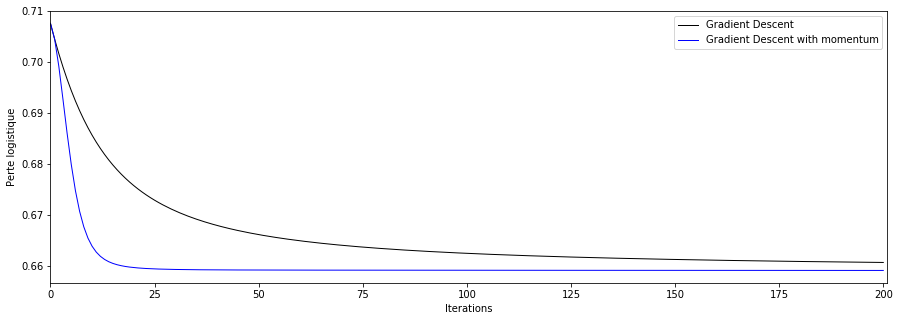

In [179]:
utilsLab1.iteration_plot(2, f=np.array([f_GD, f_GD_Momentum]).T,  
                         label=["Gradient Descent", 
                                "Gradient Descent with momentum"])

## Mini-Batch Gradient Descent

In [163]:
def miniBatchGD(data, w0=None, learningRate=0.02, momentum=0.0, nesterov=False, 
                lambda1=0.0, lambda2=0.0,
                iterations=10, sampleSize=100, progress=False):
    
    numFeatures = len(data.take(1)[0].features)
    trainSize = data.count()
    v = np.zeros(numFeatures)
    if w0 is None:
        w = np.random.normal(size=numFeatures)
    else:
        w = w0
    
    f = np.array([data.map(lambda example: Ji(example, w)).reduce(add)/trainSize])   
    
    ts = timeit.default_timer()
    
    for k in range(iterations):
        
        # choose randomly sampleSize examples (sampling)
        fraction = float(sampleSize)/float(trainSize)
        sampleRDD = trainRDD.sample(False, fraction)
        sampleSize = sampleRDD.count()
        
        if nesterov:
            w_nesterov = w - momentum*v
        else:
            w_nesterov = w
        
        wBroadcast = sc.broadcast(w_nesterov)
        gradient = sampleRDD.map(lambda example: gradJi(example, wBroadcast.value)).reduce(add)
        #gradient = sampleRDD.map(lambda example: gradJi(example, w_nesterov)).reduce(add)
        v = momentum*v + learningRate*gradient/sampleSize
        w += -v
        
        fval = np.array([data.map(lambda example: Ji(example, w)).reduce(add)/trainSize])  
        f = np.vstack((f, fval))
        
        # progress trace
        if (progress==True) and (k%(iterations/10)==0):
            utilsLab1.show_progress2(k, fval, gradient)
    
    te =  timeit.default_timer()  
    
    if (progress==True):
        print("\n*** Mini-Batch Gradient Descent *** (", np.round(te-ts,2), "seconds)")
        utilsLab1.show_progress2(k, fval, gradient)
        
    return w,f.reshape(iterations+1,)

In [167]:
w_miniGD, f_miniGD = miniBatchGD(trainRDD.cache(), w0=np.array(W_INITIAL),
                                 learningRate=alpha,
                                 iterations=ITER_MAX, sampleSize=1000, progress=True)

epoch 1     f(w)=0.7048   Grad_f(w)=26.949330
epoch 21    f(w)=0.6747   Grad_f(w)=17.893490
epoch 41    f(w)=0.6674   Grad_f(w)=7.687878
epoch 61    f(w)=0.6645   Grad_f(w)=5.210606
epoch 81    f(w)=0.6631   Grad_f(w)=1.728514
epoch 101   f(w)=0.6623   Grad_f(w)=1.914864
epoch 121   f(w)=0.6617   Grad_f(w)=1.749742
epoch 141   f(w)=0.6613   Grad_f(w)=1.216209
epoch 161   f(w)=0.6610   Grad_f(w)=1.022478
epoch 181   f(w)=0.6608   Grad_f(w)=0.861695

*** Mini-Batch Gradient Descent *** ( 56.97 seconds)
epoch 200   f(w)=0.6606   Grad_f(w)=0.781786


In [168]:
w_miniGD_m, f_miniGD_m = miniBatchGD(trainRDD.cache(), w0=np.array(W_INITIAL),
                                     learningRate=alpha, momentum=0.9, nesterov=True,
                                     iterations=ITER_MAX, sampleSize=1000, progress=True)

epoch 1     f(w)=0.7052   Grad_f(w)=24.460228
epoch 21    f(w)=0.6596   Grad_f(w)=0.782497
epoch 41    f(w)=0.6592   Grad_f(w)=0.231299
epoch 61    f(w)=0.6591   Grad_f(w)=0.179140
epoch 81    f(w)=0.6591   Grad_f(w)=0.138757
epoch 101   f(w)=0.6591   Grad_f(w)=0.100540
epoch 121   f(w)=0.6591   Grad_f(w)=0.097338
epoch 141   f(w)=0.6591   Grad_f(w)=0.083117
epoch 161   f(w)=0.6591   Grad_f(w)=0.075927
epoch 181   f(w)=0.6590   Grad_f(w)=0.068592

*** Mini-Batch Gradient Descent *** ( 58.19 seconds)
epoch 200   f(w)=0.6590   Grad_f(w)=0.038117


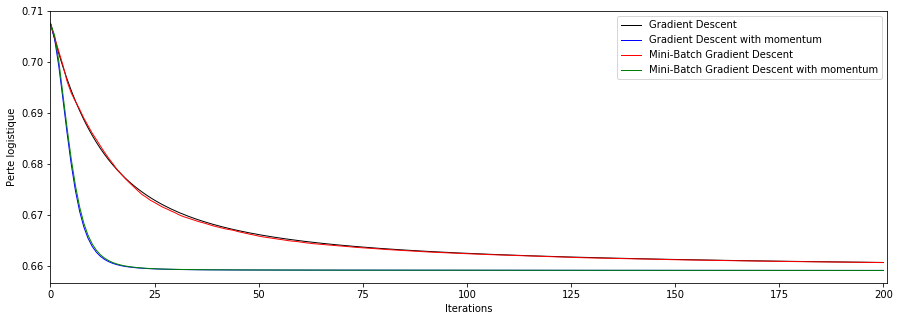

In [178]:
utilsLab1.iteration_plot(4, f=np.array([f_GD, f_GD_Momentum, f_miniGD, f_miniGD_m]).T,  
                         label=["Gradient Descent", 
                                "Gradient Descent with momentum", 
                                "Mini-Batch Gradient Descent",
                                "Mini-Batch Gradient Descent with momentum"])

## FISTA

In [ ]:
TODO TODO

In [189]:
# stop Spark
sc.stop()

# Références

[1] HOGWILD!: A Lock-Free Approach to Parallelizing Stochastic Gradient Descent. Feng Niu, Benjamin Recht, Christopher Re, Stephen J. Wright - http://arxiv.org/abs/1106.5730

[2] [Downpour SGD](http://static.googleusercontent.com/media/research.google.com/en//archive/large_deep_networks_nips2012.pdf) - Jeffrey Dean, Greg S. Corrado, Rajat Monga, Kai Chen, Matthieu Devin, Quoc V. Le, Mark Z. Mao, Marc Aurelio Ranzato, Andrew Senior, Paul Tucker, Ke Yang, and Andrew Y. Ng. Large Scale Distributed Deep Networks. NIPS 2012: Neural Information Processing Systems, pages 1–11, 2012.